# Clustering Jerarquico

In [11]:
from mp_api.client import MPRester
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mp_api.client import MPRester
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
import random

In [7]:
# Cargar base de datos de conductores, estos son con bandgap = 0
api_key = 'Q4KseBQeiCIFmpyIzcxTaWeQ0DVWzyZf'

random.seed(43)

with MPRester(api_key) as mpr:
    # La cantidad de materiales que tienen bandgap = 0 son 72223 y me quedo sin ram
    # tomaré aleatoriamente 7000 (10% de los datos)
    mp_ids = mpr.materials.summary.search(band_gap=(0,0), fields=['material_id'])
    mp_ids = [mp_id.material_id for mp_id in mp_ids]
    mp_ids = random.sample(mp_ids,7000)
    
    docs = mpr.materials.summary.search(material_ids=mp_ids)

# Liberamos memoria para no sobrecargar la ram
del mp_ids

Retrieving SummaryDoc documents:   0%|          | 0/72223 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7000 [00:00<?, ?it/s]

In [9]:
# Convertimos todo esto a un dataframe
df = pd.DataFrame([material.__dict__ for material in docs])

del docs


In [158]:
# Aplicar algún método de reducción de dimensionalidad o selección de características para simplificar los datos
# En este ejemplo, se usa la función auto_featurize de matminer para generar automáticamente características a partir de la composición química
# Se usan las siguientes clases de características: ElementProperty, Stoichiometry, ValenceOrbital, IonProperty y ElementFraction
feature_classes = [cf.ElementProperty.from_preset("magpie"), cf.Stoichiometry(), cf.ValenceOrbital(props=["avg"]), cf.IonProperty(), cf.ElementFraction()]
featurizer = cf.ElementProperty.from_preset("magpie")
X = featurizer.fit_transform(df['composition'])

X_df = pd.DataFrame(X)
X_df = X_df.dropna(axis=1) # Eliminar las columnas con valores nulos

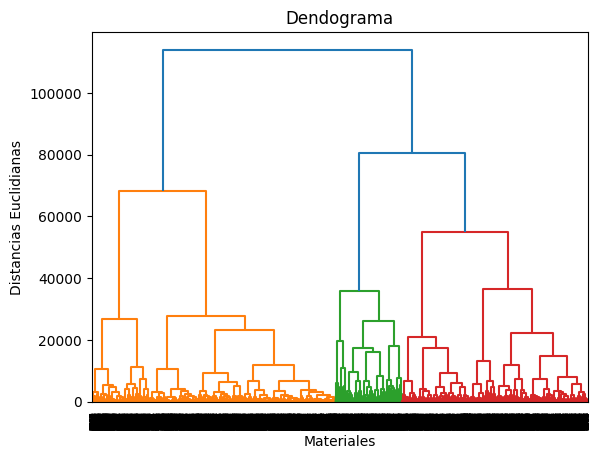

In [159]:
# Creamos el dendograma para encontrar el número óptimo de clusters

import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_df, method = 'ward'))

plt.title('Dendograma')
plt.xlabel('Materiales')
plt.ylabel('Distancias Euclidianas')
plt.show()

In [160]:
# Ajustando Clustering Jerárquico al conjunto de datos
from sklearn.cluster import AgglomerativeClustering

y_hcs = []
for i in range(1,6):
    hc = AgglomerativeClustering(n_clusters = i, 
                    metric = 'euclidean', 
                    linkage = 'ward')

    y_hc = hc.fit_predict(X_df)
    y_hcs.append(y_hc)

In [161]:
y_hcs[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

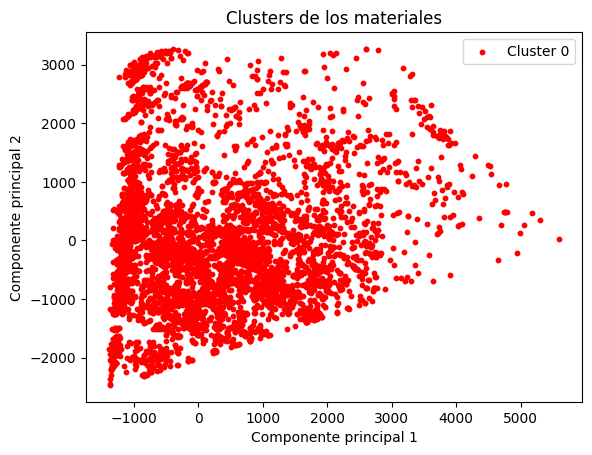

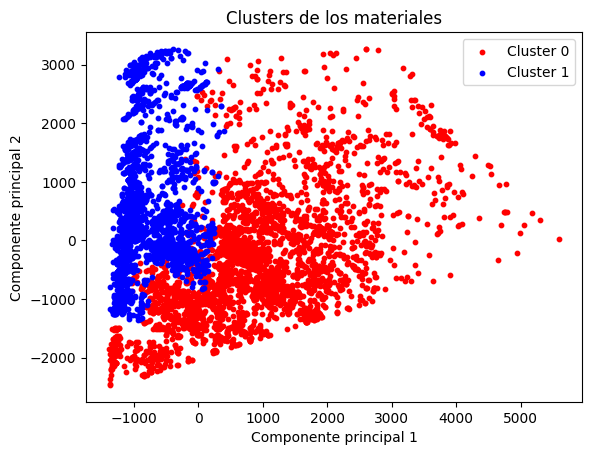

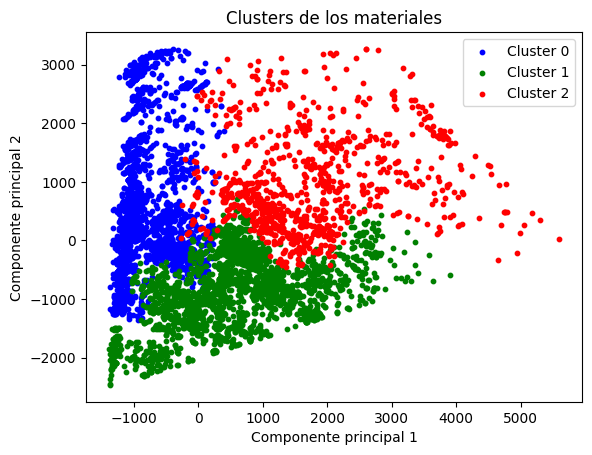

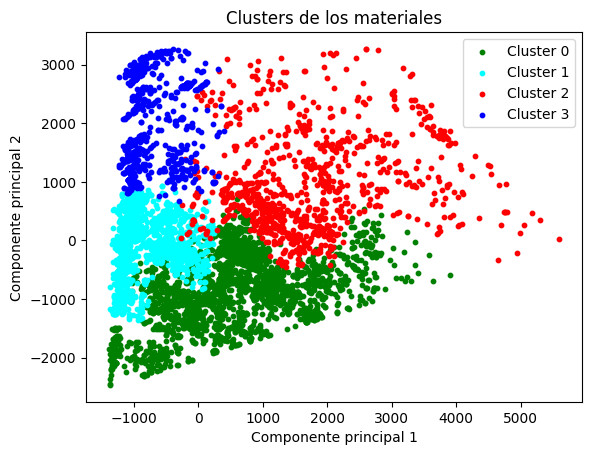

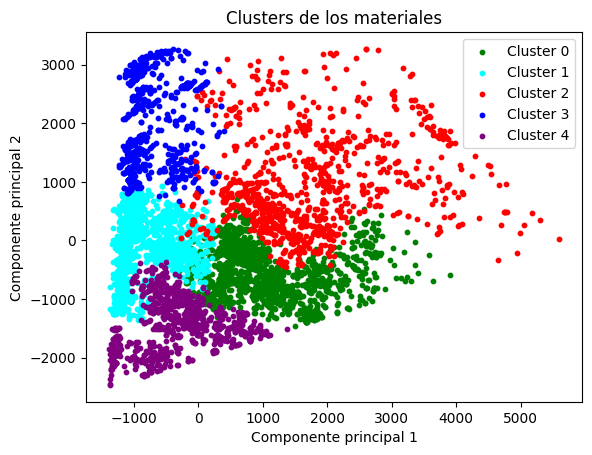

In [162]:
# Visualización de los clusters

# Hacemos PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_df)

colors = [['red'], ['red', 'blue'], ['blue', 'green', 'red'], ['green', 'cyan', 'red', 'blue'], ['green', 'cyan', 'red', 'blue', 'purple']]

#Graficos
plt.figure(1)
plt.scatter(X_pca[y_hcs[0] == 0, 0], X_pca[y_hcs[0] == 0, 1], s = 10, c = colors[0][0], label = 'Cluster ' + str(0))
plt.title('Clusters de los materiales')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend()
plt.show()


for i in range(2,6):
    plt.figure(i)
    for j in range(i):
        plt.scatter(X_pca[y_hcs[i-1] == j, 0], X_pca[y_hcs[i-1] == j, 1], s = 10, c = colors[i-1][j], label = 'Cluster ' + str(j))
    plt.title('Clusters de los materiales')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    plt.legend()
    plt.show()

In [163]:
df['2clusters'] = y_hcs[1]
df['3clusters'] = y_hcs[2]
df['4clusters'] = y_hcs[3]
df['5clusters'] = y_hcs[4]

In [164]:
clusters20 = df[df['2clusters'] == 0] 
clusters21 = df[df['2clusters'] == 1]

clusters30 = df[df['3clusters'] == 0] 
clusters31 = df[df['3clusters'] == 1]
clusters32 = df[df['3clusters'] == 2]

clusters40 = df[df['4clusters'] == 0] 
clusters41 = df[df['4clusters'] == 1]
clusters42 = df[df['4clusters'] == 2]
clusters43 = df[df['4clusters'] == 3]

clusters50 = df[df['5clusters'] == 0] 
clusters51 = df[df['5clusters'] == 1]
clusters52 = df[df['5clusters'] == 2]
clusters53 = df[df['5clusters'] == 3]
clusters54 = df[df['5clusters'] == 4]

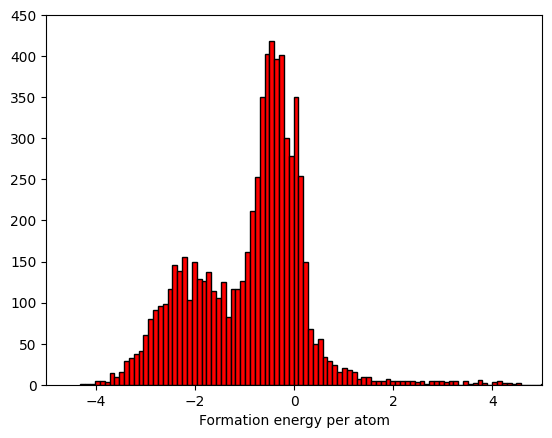

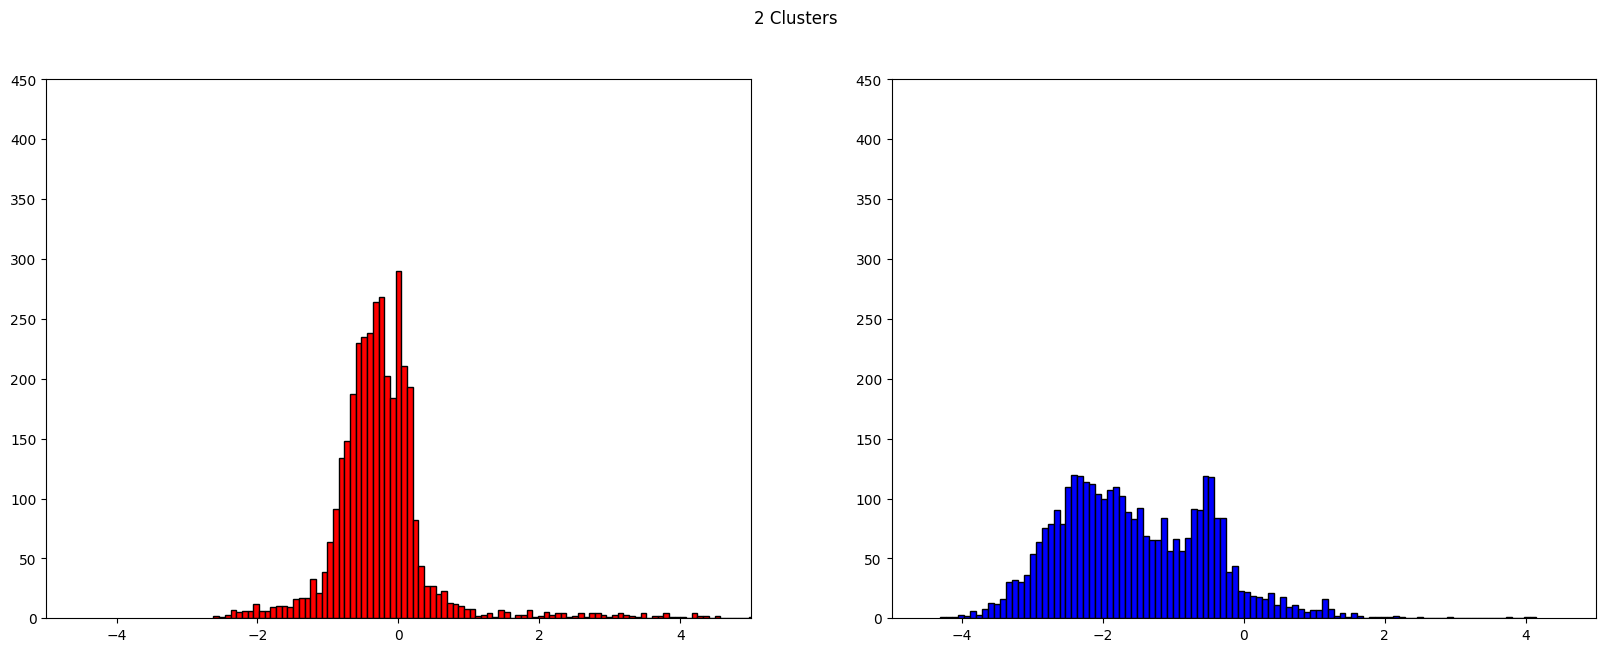

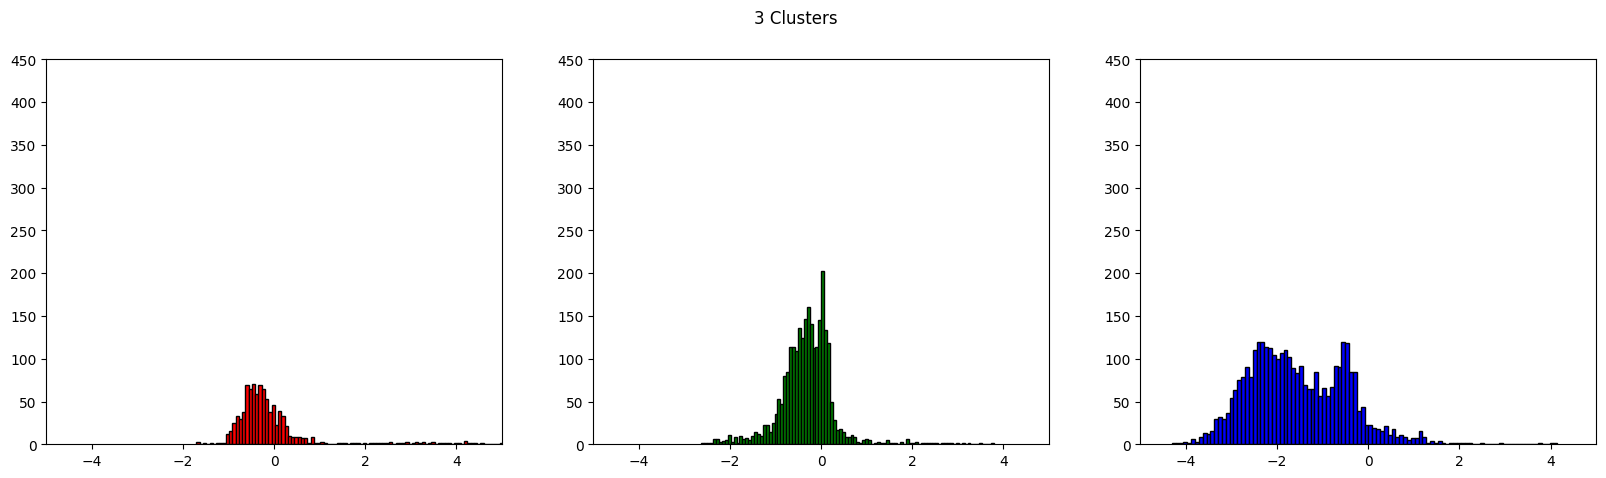

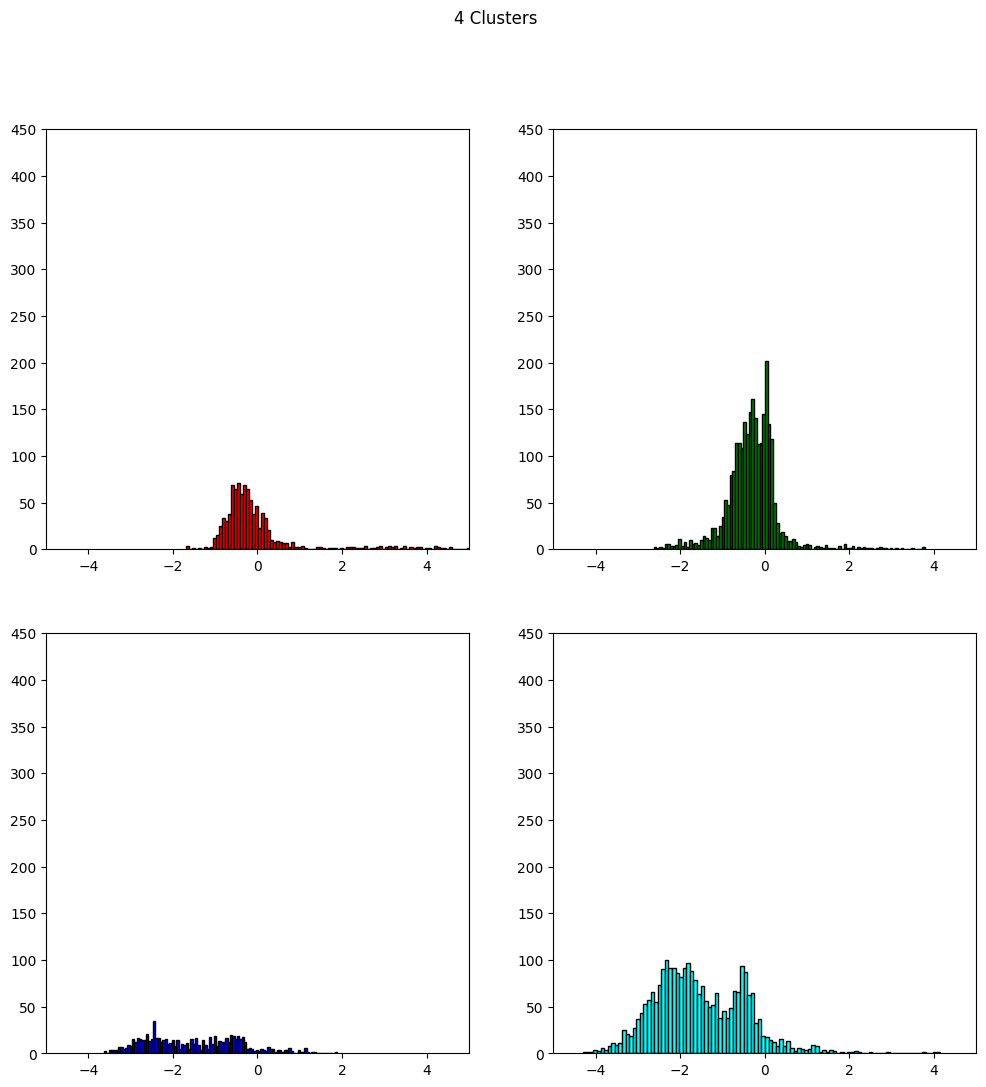

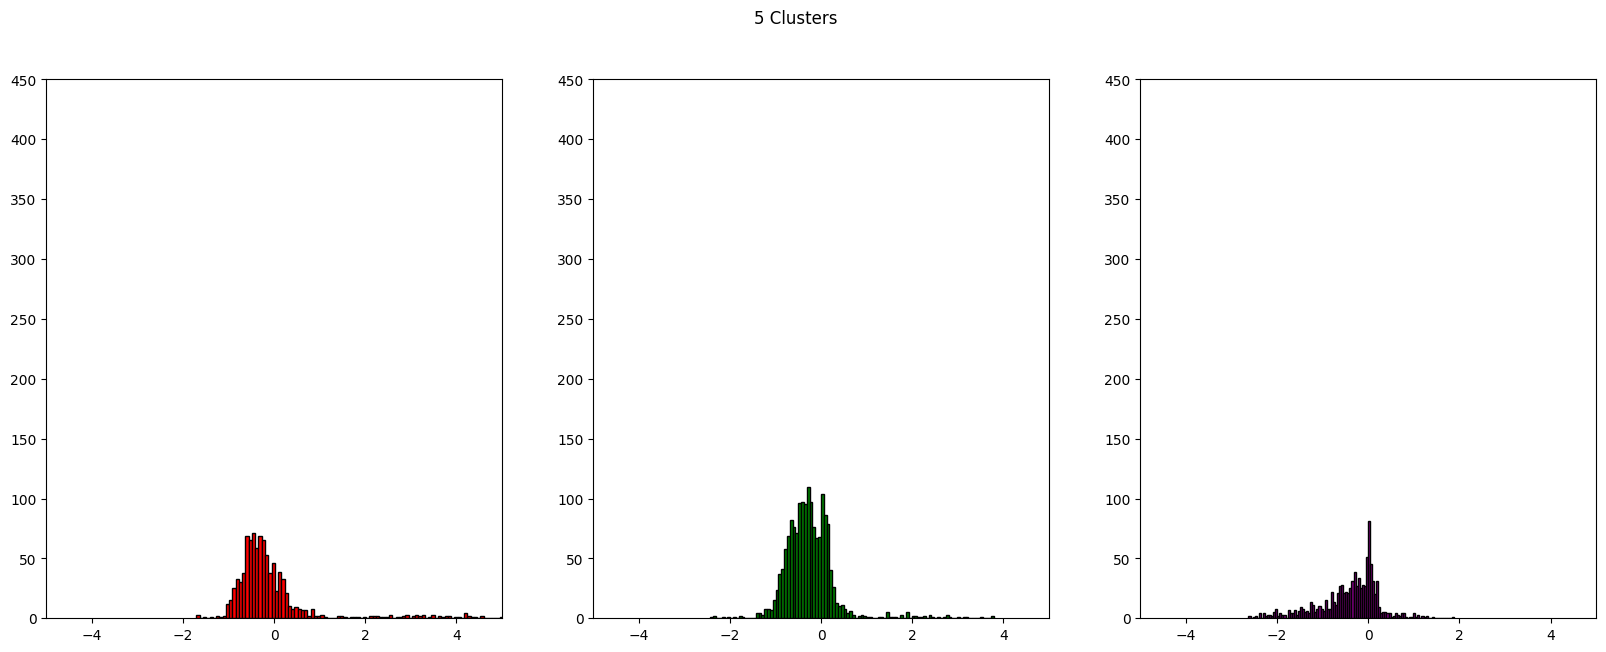

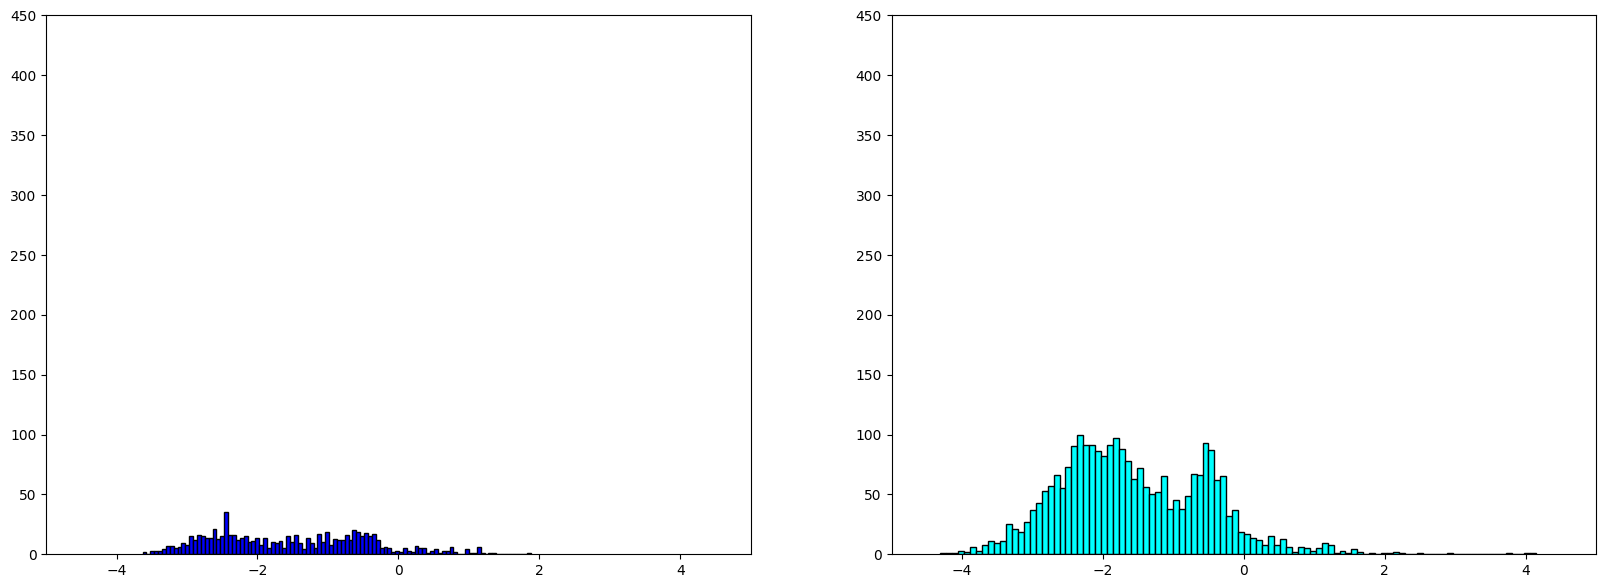

In [165]:
# Todo
plt.figure(0)
plt.hist(df["formation_energy_per_atom"],bins=100, color='red', edgecolor='black')
plt.xlabel("Formation energy per atom")
plt.xlim(-5,5)
plt.ylim(0,450)
plt.show()

# 2 clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
fig.suptitle('2 Clusters')
ax1.hist(clusters20['formation_energy_per_atom'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-5,5)
ax1.set_ylim(0,450)

ax2.hist(clusters21['formation_energy_per_atom'],bins=100, color='blue', edgecolor='black')
ax2.set_xlim(-5,5)
ax2.set_ylim(0,450)
plt.show()

# 3 clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('3 Clusters')
ax1.hist(clusters32['formation_energy_per_atom'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-5,5)
ax1.set_ylim(0,450)

ax2.hist(clusters31['formation_energy_per_atom'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(-5,5)
ax2.set_ylim(0,450)

ax3.hist(clusters30['formation_energy_per_atom'],bins=100, color='blue', edgecolor='black')
ax3.set_xlim(-5,5)
ax3.set_ylim(0,450)
plt.show()

# 4 clusters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('4 Clusters')
ax1.hist(clusters42['formation_energy_per_atom'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-5,5)
ax1.set_ylim(0,450)

ax2.hist(clusters40['formation_energy_per_atom'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(-5,5)
ax2.set_ylim(0,450)

ax3.hist(clusters43['formation_energy_per_atom'],bins=100, color='blue', edgecolor='black')
ax3.set_xlim(-5,5)
ax3.set_ylim(0,450)

ax4.hist(clusters41['formation_energy_per_atom'],bins=100, color='cyan', edgecolor='black')
ax4.set_xlim(-5,5)
ax4.set_ylim(0,450)
plt.show()

# 5 clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('5 Clusters')
ax1.hist(clusters52['formation_energy_per_atom'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-5,5)
ax1.set_ylim(0,450)

ax2.hist(clusters50['formation_energy_per_atom'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(-5,5)
ax2.set_ylim(0,450)

ax3.hist(clusters54['formation_energy_per_atom'],bins=100, color='purple', edgecolor='black')
ax3.set_xlim(-5,5)
ax3.set_ylim(0,450)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.hist(clusters53['formation_energy_per_atom'],bins=100, color='blue', edgecolor='black')
ax1.set_xlim(-5,5)
ax1.set_ylim(0,450)

ax2.hist(clusters51['formation_energy_per_atom'],bins=100, color='cyan', edgecolor='black')
ax2.set_xlim(-5,5)
ax2.set_ylim(0,450)
plt.show()

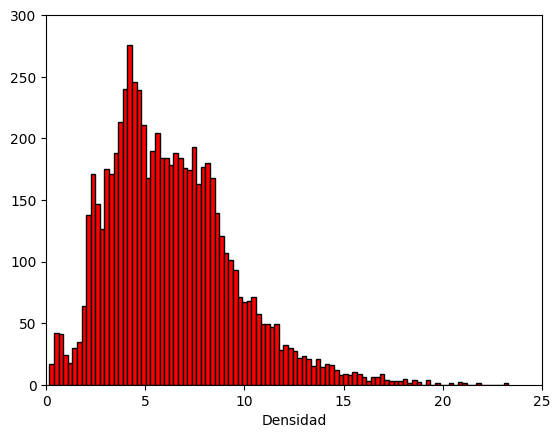

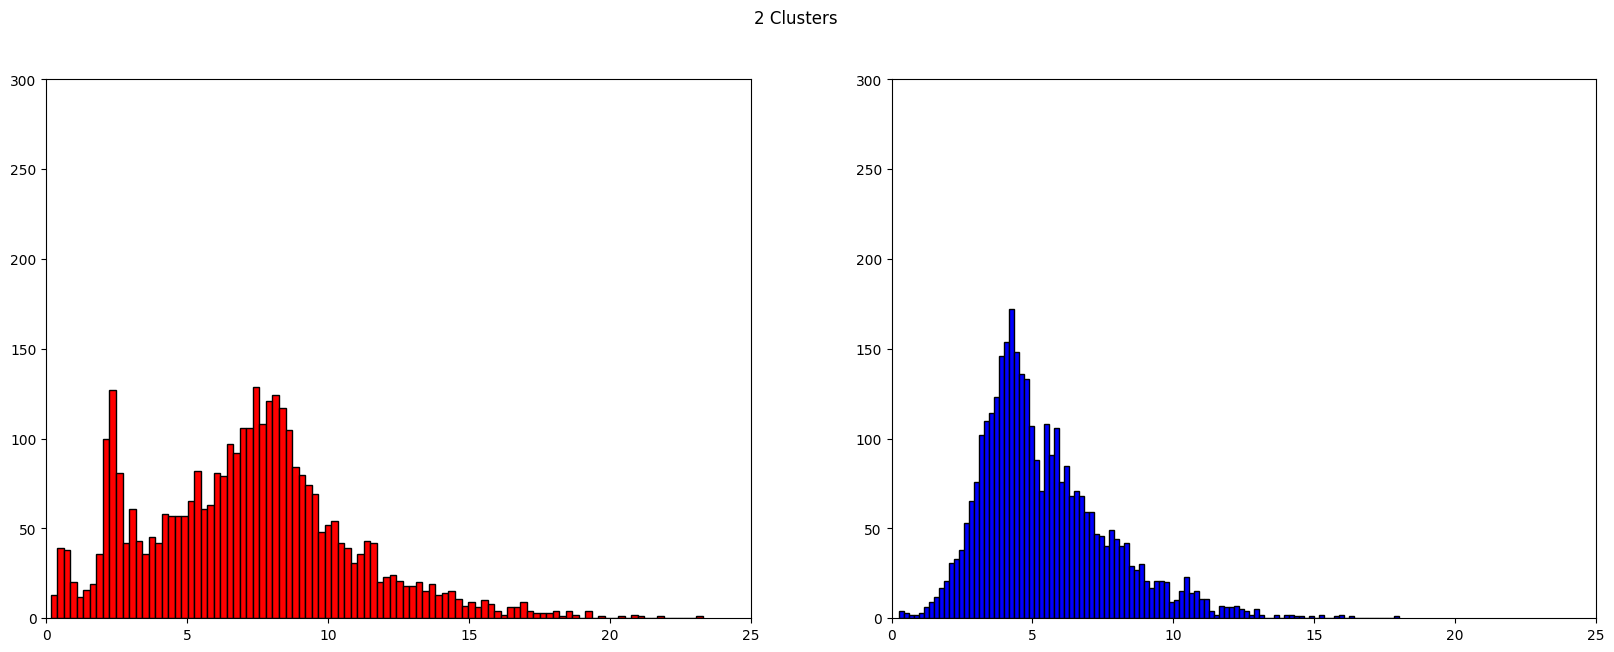

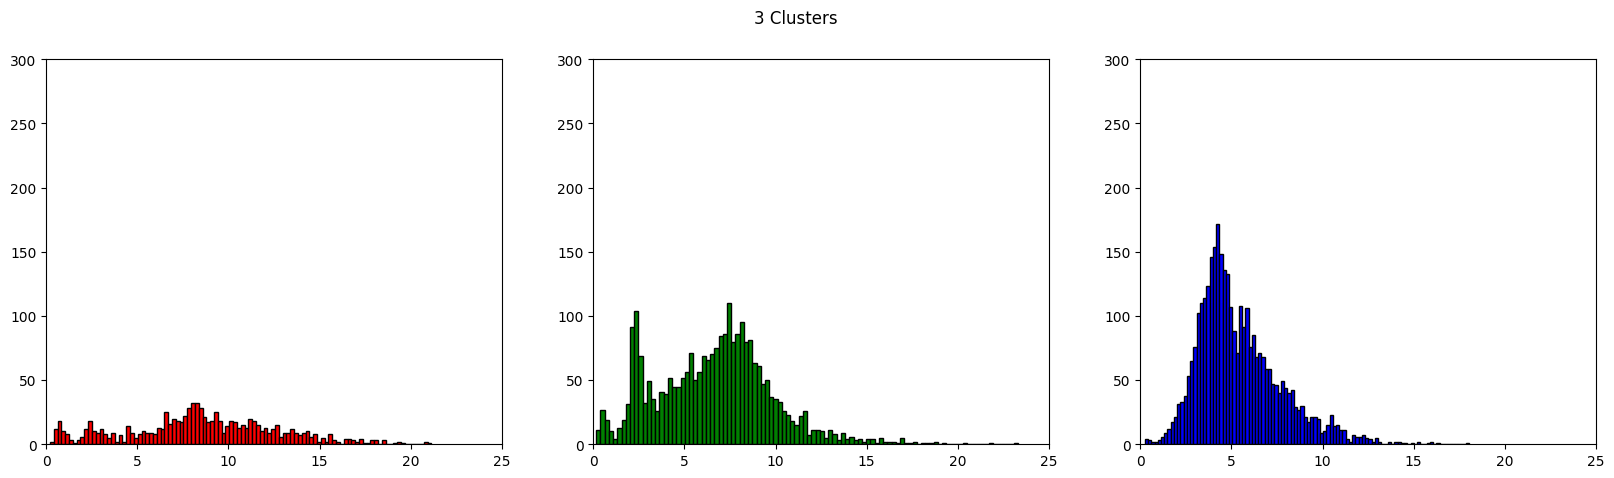

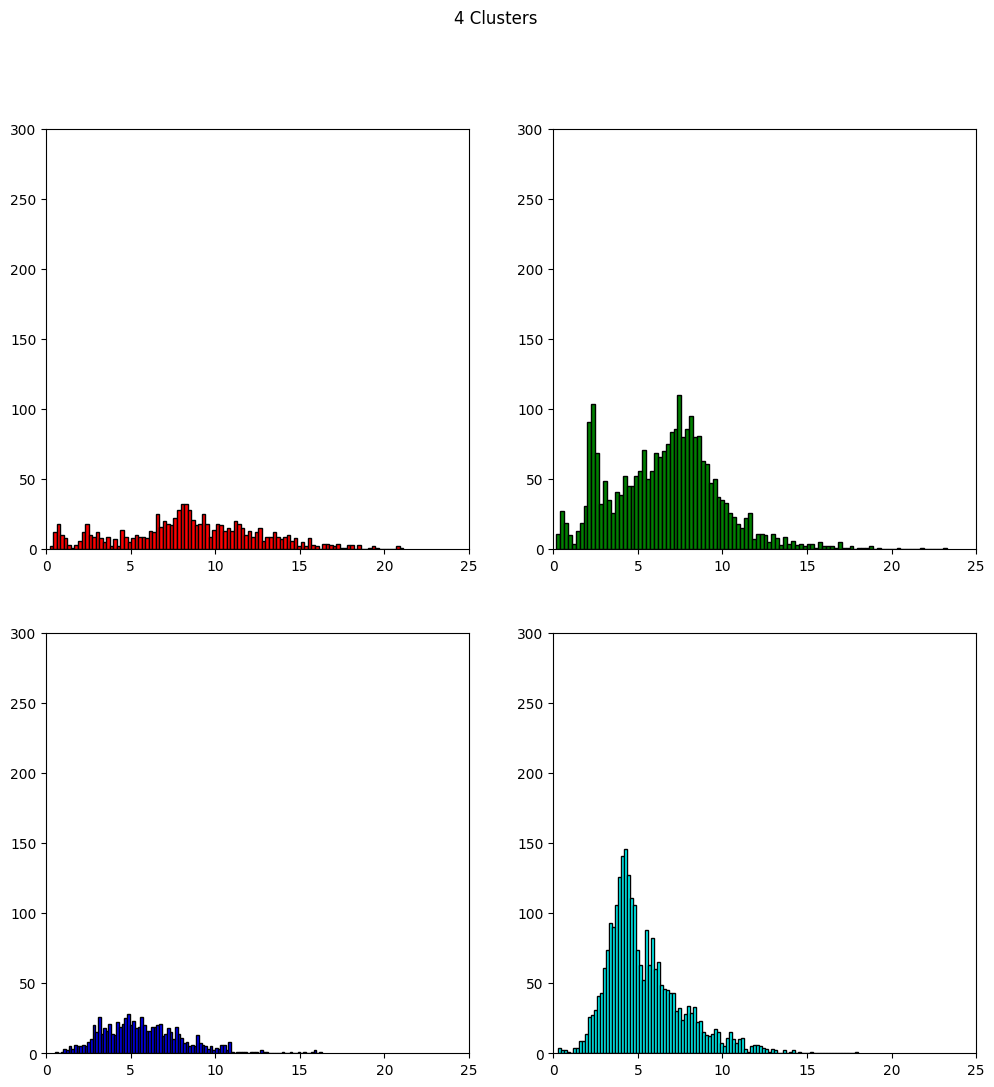

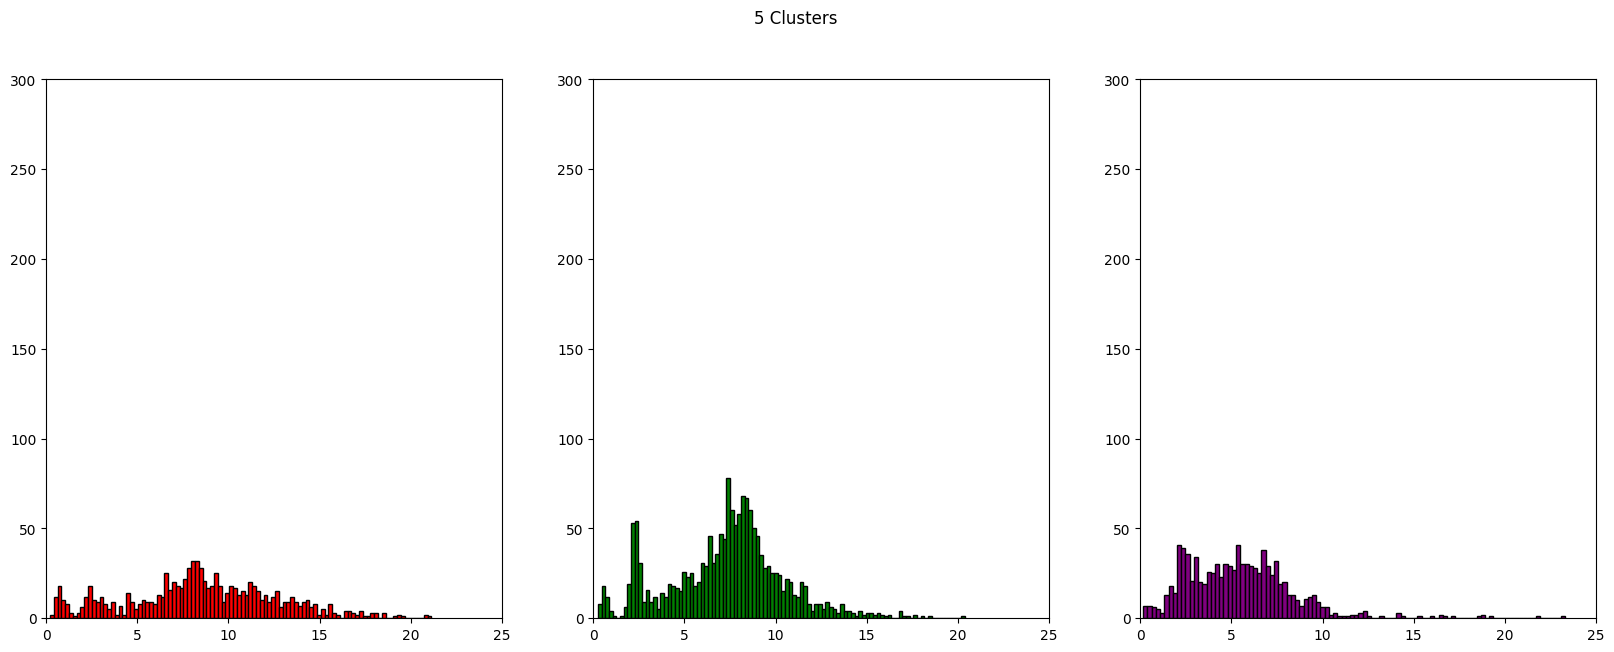

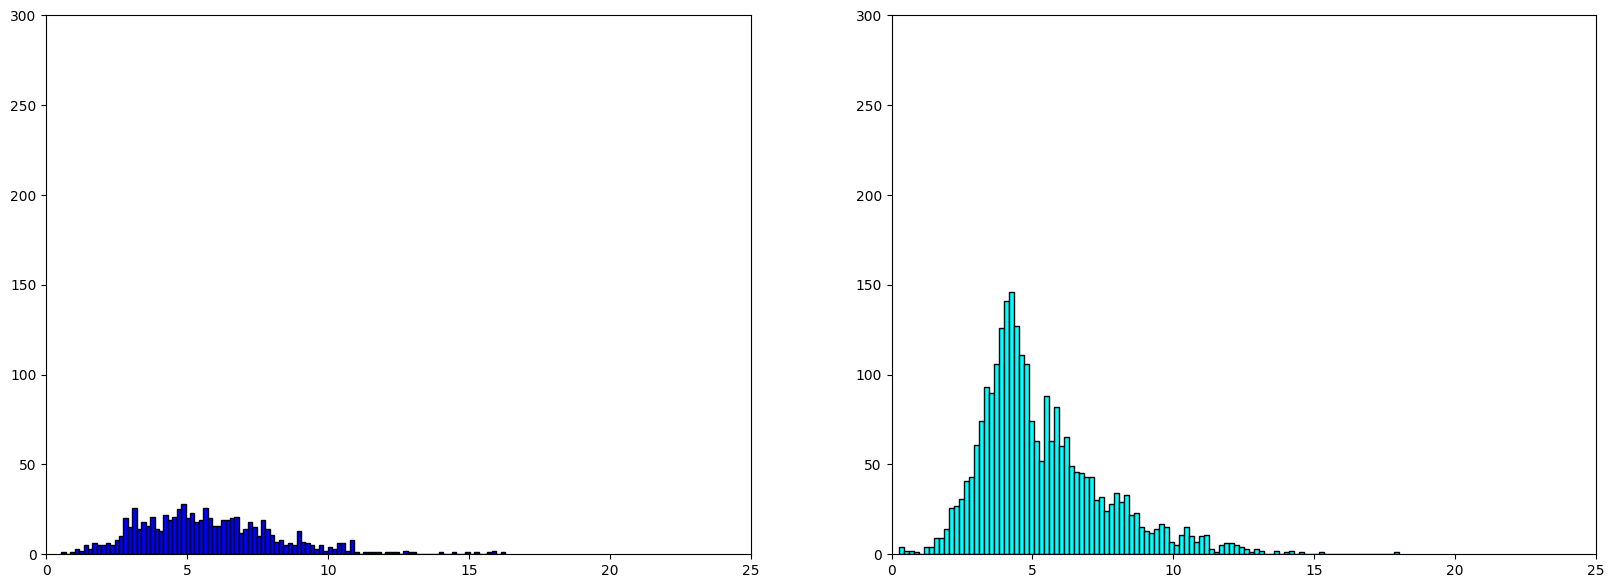

In [166]:
# Todo
plt.figure(0)
plt.hist(df["density"],bins=100, color='red', edgecolor='black')
plt.xlabel("Densidad")
plt.xlim(0,25)
plt.ylim(0,300)
plt.show()

# 2 clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
fig.suptitle('2 Clusters')
ax1.hist(clusters20['density'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(0,25)
ax1.set_ylim(0,300)

ax2.hist(clusters21['density'],bins=100, color='blue', edgecolor='black')
ax2.set_xlim(0,25)
ax2.set_ylim(0,300)
plt.show()

# 3 clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('3 Clusters')
ax1.hist(clusters32['density'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(0,25)
ax1.set_ylim(0,300)

ax2.hist(clusters31['density'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(0,25)
ax2.set_ylim(0,300)

ax3.hist(clusters30['density'],bins=100, color='blue', edgecolor='black')
ax3.set_xlim(0,25)
ax3.set_ylim(0,300)
plt.show()

# 4 clusters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('4 Clusters')
ax1.hist(clusters42['density'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(0,25)
ax1.set_ylim(0,300)

ax2.hist(clusters40['density'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(0,25)
ax2.set_ylim(0,300)

ax3.hist(clusters43['density'],bins=100, color='blue', edgecolor='black')
ax3.set_xlim(0,25)
ax3.set_ylim(0,300)

ax4.hist(clusters41['density'],bins=100, color='cyan', edgecolor='black')
ax4.set_xlim(0,25)
ax4.set_ylim(0,300)
plt.show()

# 5 clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('5 Clusters')
ax1.hist(clusters52['density'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(0,25)
ax1.set_ylim(0,300)

ax2.hist(clusters50['density'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(0,25)
ax2.set_ylim(0,300)

ax3.hist(clusters54['density'],bins=100, color='purple', edgecolor='black')
ax3.set_xlim(0,25)
ax3.set_ylim(0,300)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.hist(clusters53['density'],bins=100, color='blue', edgecolor='black')
ax1.set_xlim(0,25)
ax1.set_ylim(0,300)

ax2.hist(clusters51['density'],bins=100, color='cyan', edgecolor='black')
ax2.set_xlim(0,25)
ax2.set_ylim(0,300)
plt.show()

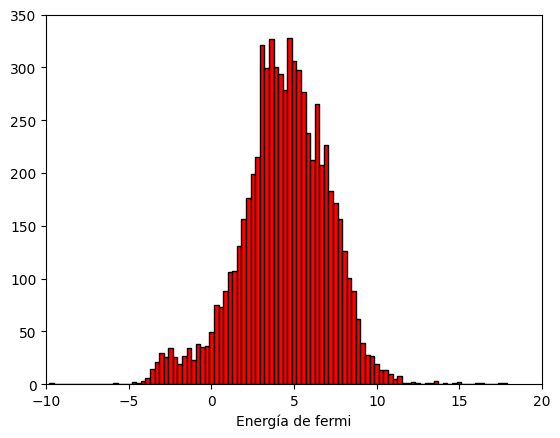

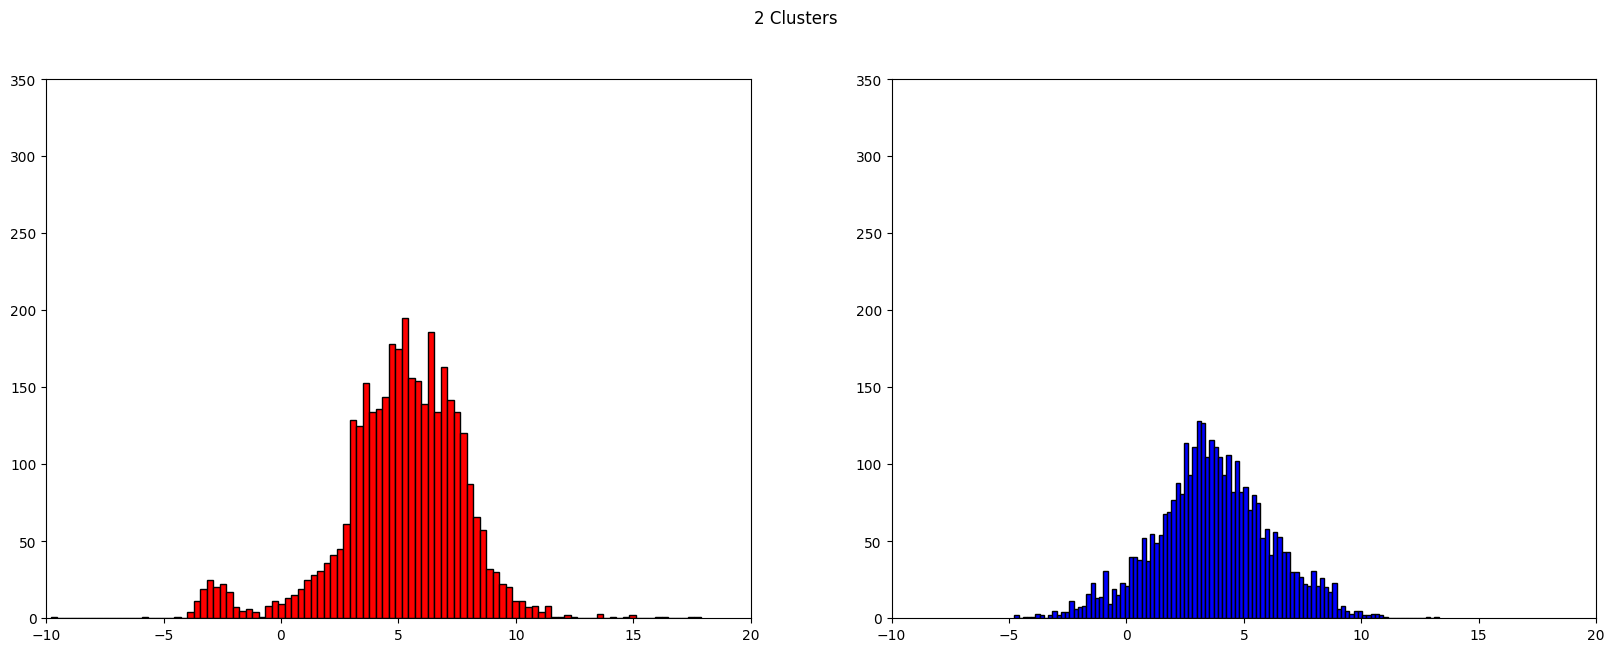

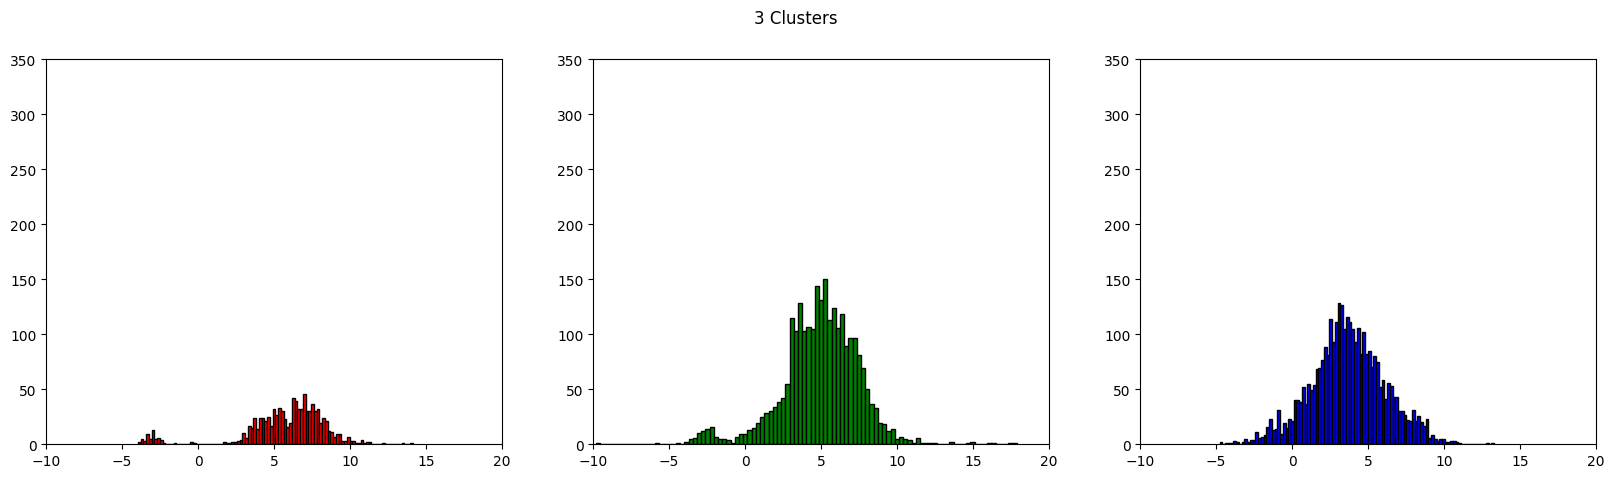

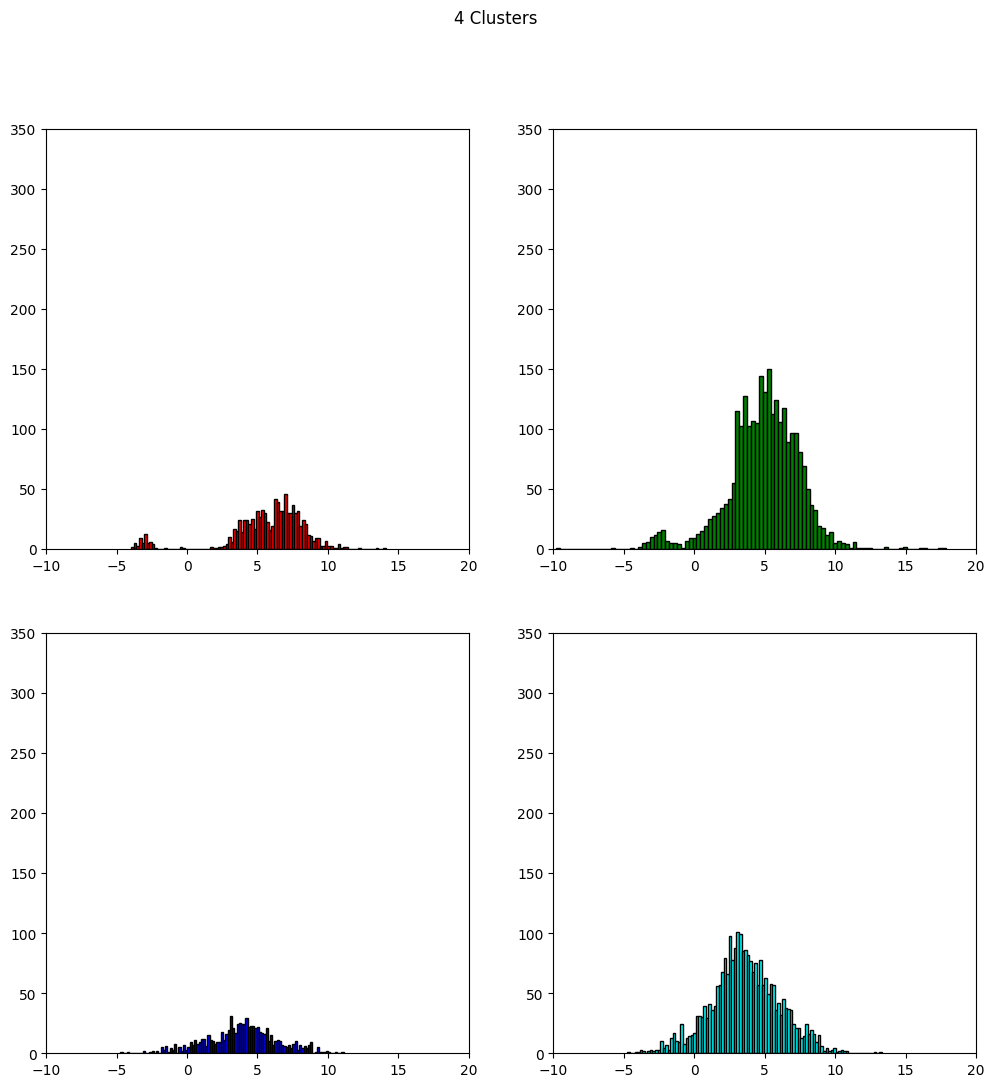

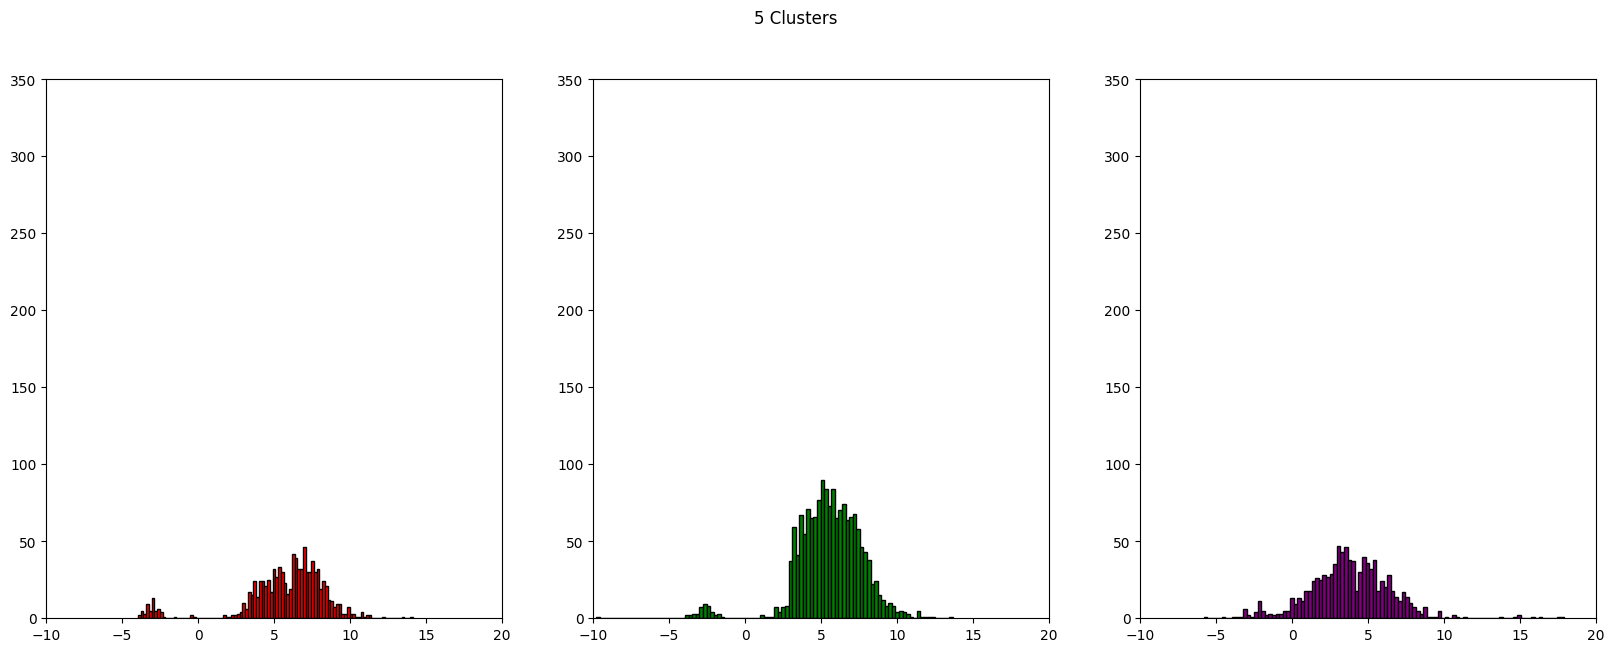

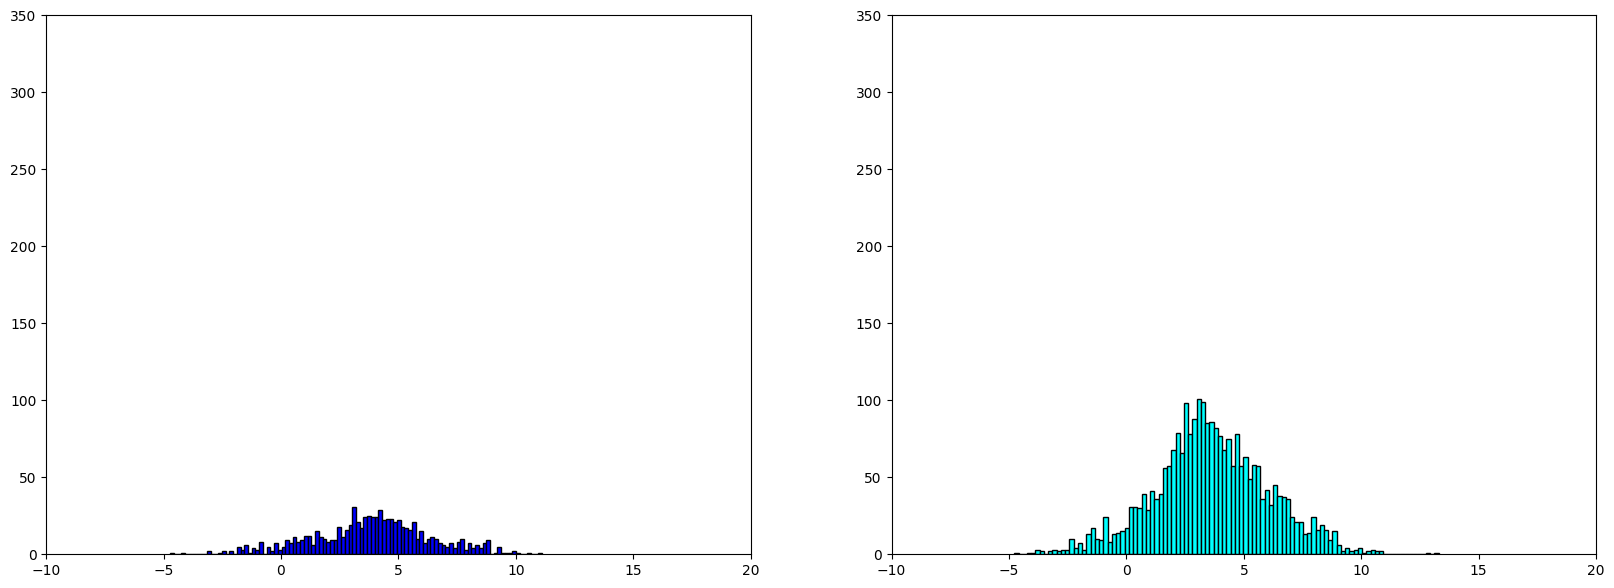

In [167]:
# Todo
plt.figure(0)
plt.hist(df["efermi"],bins=100, color='red', edgecolor='black')
plt.xlabel("Energía de fermi")
plt.xlim(-10,20)
plt.ylim(0,350)
plt.show()

# 2 clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
fig.suptitle('2 Clusters')
ax1.hist(clusters20['efermi'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-10,20)
ax1.set_ylim(0,350)

ax2.hist(clusters21['efermi'],bins=100, color='blue', edgecolor='black')
ax2.set_xlim(-10,20)
ax2.set_ylim(0,350)
plt.show()

# 3 clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('3 Clusters')
ax1.hist(clusters32['efermi'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-10,20)
ax1.set_ylim(0,350)

ax2.hist(clusters31['efermi'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(-10,20)
ax2.set_ylim(0,350)

ax3.hist(clusters30['efermi'],bins=100, color='blue', edgecolor='black')
ax3.set_xlim(-10,20)
ax3.set_ylim(0,350)
plt.show()

# 4 clusters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('4 Clusters')
ax1.hist(clusters42['efermi'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-10,20)
ax1.set_ylim(0,350)

ax2.hist(clusters40['efermi'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(-10,20)
ax2.set_ylim(0,350)

ax3.hist(clusters43['efermi'],bins=100, color='blue', edgecolor='black')
ax3.set_xlim(-10,20)
ax3.set_ylim(0,350)

ax4.hist(clusters41['efermi'],bins=100, color='cyan', edgecolor='black')
ax4.set_xlim(-10,20)
ax4.set_ylim(0,350)
plt.show()

# 5 clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('5 Clusters')
ax1.hist(clusters52['efermi'],bins=100, color='red', edgecolor='black')
ax1.set_xlim(-10,20)
ax1.set_ylim(0,350)

ax2.hist(clusters50['efermi'],bins=100, color='green', edgecolor='black')
ax2.set_xlim(-10,20)
ax2.set_ylim(0,350)

ax3.hist(clusters54['efermi'],bins=100, color='purple', edgecolor='black')
ax3.set_xlim(-10,20)
ax3.set_ylim(0,350)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.hist(clusters53['efermi'],bins=100, color='blue', edgecolor='black')
ax1.set_xlim(-10,20)
ax1.set_ylim(0,350)

ax2.hist(clusters51['efermi'],bins=100, color='cyan', edgecolor='black')
ax2.set_xlim(-10,20)
ax2.set_ylim(0,350)
plt.show()

In [168]:
X

[[8.0,
  67.0,
  59.0,
  25.727272727272727,
  21.834710743801654,
  8.0,
  9.0,
  87.0,
  78.0,
  63.36363636363637,
  26.628099173553718,
  87.0,
  15.9994,
  164.93032,
  148.93092,
  60.08688363636363,
  54.60123371900826,
  15.9994,
  54.8,
  2607.0,
  2552.2,
  691.4363636363637,
  694.5123966942149,
  54.8,
  2.0,
  16.0,
  14.0,
  10.272727272727273,
  6.24793388429752,
  16.0,
  2.0,
  6.0,
  4.0,
  3.4545454545454546,
  1.6694214876033058,
  2.0,
  66.0,
  215.0,
  149.0,
  118.63636363636364,
  57.42148760330579,
  66.0,
  0.89,
  3.44,
  2.55,
  2.4690909090909092,
  1.0591735537190081,
  3.44,
  1.0,
  2.0,
  1.0,
  1.9090909090909092,
  0.16528925619834703,
  2.0,
  0.0,
  4.0,
  4.0,
  2.1818181818181817,
  1.9834710743801656,
  4.0,
  0.0,
  7.0,
  7.0,
  0.6363636363636364,
  1.1570247933884297,
  0.0,
  0.0,
  11.0,
  11.0,
  1.0,
  1.8181818181818181,
  0.0,
  2.0,
  13.0,
  11.0,
  5.7272727272727275,
  2.033057851239669,
  6.0,
  0.0,
  1.0,
  1.0,
  0.090909090909

In [141]:
df.columns

Index(['builder_meta', 'nsites', 'elements', 'nelements', 'composition',
       'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys',
       'volume', 'density', 'density_atomic', 'symmetry', 'property_name',
       'material_id', 'deprecated', 'deprecation_reasons', 'last_updated',
       'origins', 'warnings', 'structure', 'task_ids',
       'uncorrected_energy_per_atom', 'energy_per_atom',
       'formation_energy_per_atom', 'energy_above_hull', 'is_stable',
       'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas',
       'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct',
       'is_metal', 'es_source_calc_id', 'bandstructure', 'dos',
       'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering',
       'total_magnetization', 'total_magnetization_normalized_vol',
       'total_magnetization_normalized_formula_units', 'num_magnetic_sites',
       'num_unique_magnetic_sites', 'types_of_magnetic_species',
       'bulk_modulus

In [153]:
df['efermi']

0       4.431957
1       3.631556
2       2.220466
3       3.523939
4       7.429444
          ...   
6995    7.355046
6996    2.034045
6997    4.440732
6998    2.778606
6999    4.260274
Name: efermi, Length: 7000, dtype: float64